In [1]:
from typing import *
import os
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import swifter
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from tqdm.notebook import tqdm
from nptyping import NDArray, Shape, Int, Float
from rich import print as rprint

sns.set(font='IPAexGothic', style='whitegrid')
colors = ['#de3838', '#007bc3', '#ffd12a']
markers = ['o', 'x', ',']
%config InlineBackend.figure_formats = ['svg']

cmap = sns.diverging_palette(255, 0, as_cmap=True)  # カラーパレットの定義
DATA_DIR = Path()/'..'/'..'/'data'
DF_DIR = DATA_DIR/'dataframes'

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# 51

df_factories: pd.DataFrame = pd.read_csv(DATA_DIR/'tbl_factory.csv', index_col=0)
df_warehouses: pd.DataFrame = pd.read_csv(DATA_DIR/'tbl_warehouse.csv', index_col=0)
df_cost: pd.DataFrame = pd.read_csv(DATA_DIR/'rel_cost.csv', index_col=0)
df_trans: pd.DataFrame = pd.read_csv(DATA_DIR/'tbl_transaction.csv', index_col=0)

display(df_factories.tail(2))
display(df_warehouses.tail(2))
display(df_cost.tail(2))
display(df_trans.tail(2))

df_join_data: pd.DataFrame = pd.merge(df_trans, df_cost, left_on=['ToFC', 'FromWH'], right_on=['FCID', 'WHID'], how='left')

df_join_data = pd.merge(df_join_data, df_factories, left_on='ToFC', right_on='FCID', how='left')

df_join_data = pd.merge(df_join_data, df_warehouses, left_on='FromWH', right_on='WHID', how='left')

columns = ['TransactionDate', 'Quantity', 'Cost', 'ToFC', 'FCName', 'FCDemand', 'FromWH', 'WHName', 'WHSupply', 'WHRegion']
df_join_data = df_join_data[columns]
display(df_join_data.tail(2))

print(f'regions: {df_join_data["WHRegion"].unique()}')

df_kanto: pd.DataFrame = df_join_data[df_join_data['WHRegion'] == '関東'].copy().reset_index(drop=True)
display(df_kanto.tail(2))
df_tohoku: pd.DataFrame = df_join_data[df_join_data['WHRegion'] == '東北'].copy().reset_index(drop=True)
display(df_tohoku.tail(2))

df_join_data.to_pickle(DF_DIR/'join_data_k51.pkl')
df_kanto.to_pickle(DF_DIR/'kanto_k51.pkl')
df_tohoku.to_pickle(DF_DIR/'tohoku_k51.pkl')

,FCName,FCDemand,FCRegion
FCID,,,
FC00007,那須工場,25,東北
FC00008,青森工場,16,東北


,WHName,WHSupply,WHRegion
WHID,,,
WH00005,仙台倉庫,72,東北
WH00006,山形倉庫,65,東北


,FCID,WHID,Cost
RCostID,,,
23,FC00008,WH00005,1.2
24,FC00008,WH00006,1.3


,TransactionDate,ToFC,FromWH,Quantity
TRID,,,,
3998,2019-12-31 21:45:07,FC00005,WH00005,34
3999,2019-12-31 23:19:37,FC00005,WH00005,16


,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
3998,2019-12-31 21:45:07,34,0.3,FC00005,仙台工場,21,WH00005,仙台倉庫,72,東北
3999,2019-12-31 23:19:37,16,0.3,FC00005,仙台工場,21,WH00005,仙台倉庫,72,東北


regions: ['関東' '東北']


,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
1998,2019-12-31 17:10:21,35,1.6,FC00002,木更津工場,29,WH00003,豊洲倉庫,42,関東
1999,2019-12-31 19:35:07,36,1.2,FC00003,多摩工場,31,WH00001,杉並倉庫,35,関東


,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
1998,2019-12-31 21:45:07,34,0.3,FC00005,仙台工場,21,WH00005,仙台倉庫,72,東北
1999,2019-12-31 23:19:37,16,0.3,FC00005,仙台工場,21,WH00005,仙台倉庫,72,東北


In [5]:
# 52

df_kanto: pd.DataFrame = pd.read_pickle(DF_DIR/'kanto_k51.pkl')
df_tohoku: pd.DataFrame = pd.read_pickle(DF_DIR/'tohoku_k51.pkl')

print(f'関東支社の総コスト: {df_kanto["Cost"].sum()} 万円')
print(f'東北支社の総コスト: {df_tohoku["Cost"].sum()} 万円')
print(f'関東支社の総部品輸送個数: {df_kanto["Quantity"].sum()} 個')
print(f'東北支社の総部品輸送個数: {df_tohoku["Quantity"].sum()} 個')

def calc_cost_per_qty(df: pd.DataFrame) -> float:
    return df['Cost'].sum() / df['Quantity'].sum() * 10000
    
print(f'関東支社の部品1つ当たりの輸送コスト: {calc_cost_per_qty(df_kanto):.2f} 円')
print(f'東北支社の部品1つ当たりの輸送コスト: {calc_cost_per_qty(df_tohoku):.2f} 円')

関東支社の総コスト: 2189.3 万円
東北支社の総コスト: 2062.0 万円
関東支社の総部品輸送個数: 49146 個
東北支社の総部品輸送個数: 50214 個
関東支社の部品1つ当たりの輸送コスト: 445.47 円
東北支社の部品1つ当たりの輸送コスト: 410.64 円


,A,B,C,D,E
3,0.000000,0.000000,0.697631,0.060225,0.666767
4,0.670638,0.210383,0.000000,0.315428,0.000000


,A,B,C,D,E
0,0,0,2,2,1
1,0,2,0,2,1


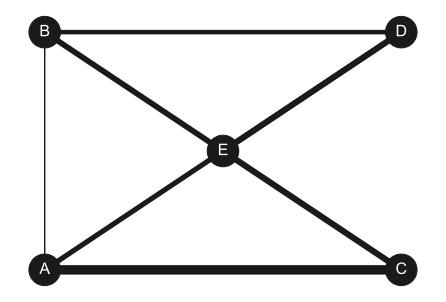

In [7]:
# 55
import networkx as nx

df_w: pd.DataFrame = pd.read_csv(DATA_DIR/'network_weight.csv')
df_p: pd.DataFrame = pd.read_csv(DATA_DIR/'network_pos.csv')

display(df_w.tail(2))
display(df_p.tail(2))

G = nx.Graph()
pos = {}

for column in df_w.columns:
    G.add_node(column)
    pos[column] = (df_p[column][0], df_p[column][1])

size = 10
num_nodes = len(df_w.columns)
edge_weights = []
for i in range(num_nodes):
    for j in range(num_nodes):
        if i != j:
            G.add_edge(df_w.columns[i], df_w.columns[j])
            edge_weights.append(df_w.iloc[i][j]*size)

nx.draw(G, pos, with_labels=True, font_size=16, node_size=1000, node_color='k', font_color='w', width=edge_weights)
plt.show()

,F1,F2,F3,F4
工場,,,,
W1,15,15,0,5
W2,5,0,30,5
W3,10,15,2,15


,W1,W2,W3,F1,F2,F3,F4
0,0,0,0,4.0,4.0,4.0,4.0
1,1,2,3,0.5,1.5,2.5,3.5


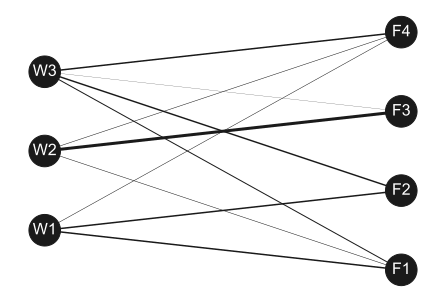

In [3]:
# 56, 57
import networkx as nx


df_tr: pd.DataFrame = pd.read_csv(DATA_DIR/'trans_route.csv', index_col='工場')
df_pos: pd.DataFrame = pd.read_csv(DATA_DIR/'trans_route_pos.csv')

display(df_tr)
display(df_pos)

G = nx.Graph()
pos = {}
for column in df_pos.columns:
    G.add_node(column)
    pos[column] = (df_pos[column][0], df_pos[column][1])

num_pre = 0
edge_weights = []
size = 0.1

def get_weight(df, node1, node2):
    weight = 0
    if (node1 in df.columns) and (node2 in df.index):
        weight = df[col1][col2] 
    elif (node2 in df.columns) and (node1 in df.index):
        weight = df[col2][col1]
    return weight

for col1 in df_pos.columns:
    for col2 in df_pos.columns:
        if col1 != col2:
            G.add_edge(col1, col2)
            if num_pre < len(G.edges):
                num_pre = len(G.edges)
                weight = get_weight(df_tr, col1, col2)
                edge_weights.append(weight*size)


nx.draw(G, pos, with_labels=True, font_size=16, node_size=1000, node_color='k', font_color='w', width=edge_weights)
plt.show()      

In [7]:
# 58

df_tr: pd.DataFrame = pd.read_csv(DATA_DIR/'trans_route.csv', index_col='工場')
df_tc: pd.DataFrame = pd.read_csv(DATA_DIR/'trans_cost.csv', index_col='工場')

display(df_tr)
display(df_tc)

def calc_trans_cost(df_tr: pd.DataFrame, df_tc: pd.DataFrame) -> float:
    cost = (df_tr.values * df_tc.values).sum()
    return cost

print(f'総運送コスト: {calc_trans_cost(df_tr, df_tc)}')

,F1,F2,F3,F4
工場,,,,
W1,15,15,0,5
W2,5,0,30,5
W3,10,15,2,15


,F1,F2,F3,F4
工場,,,,
W1,10,10,11,27
W2,18,21,12,14
W3,15,12,14,12


総運送コスト: 1493


In [8]:
# 59

df_tr: pd.DataFrame = pd.read_csv(DATA_DIR/'trans_route.csv', index_col='工場')
df_demand: pd.DataFrame = pd.read_csv(DATA_DIR/'demand.csv')
df_supply: pd.DataFrame = pd.read_csv(DATA_DIR/'supply.csv')

display(df_tr)
display(df_demand)
display(df_supply)



,F1,F2,F3,F4
工場,,,,
W1,15,15,0,5
W2,5,0,30,5
W3,10,15,2,15


,F1,F2,F3,F4
0,28,29,31,25


,W1,W2,W3
0,35,41,42
